# Word features only on toxic

The idea is to construct word features with tf-idf and word2vec and then train a simple model such as logistic regression. 

## Quick look at the shape of the data

In [65]:
from data_preparation import *

In [16]:
import pandas as pd
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


## Prepare data

In [66]:
%%time
from sklearn.pipeline import Pipeline

splitter = SentenceSplitter("comment_text")
wordEmbedding = loadWordEmbedding("../../state/external-models/glove.6B/saved-2300.bin")

allWords = splitter.transform(pd.concat([allData, contestTest]))
textWords = set([word for sentence in allWords for word in sentence])
missingWords = textWords - set(list(wordEmbedding.vocab.keys()))

missingWordsResolutionDict = loadObject("./missingWordsResolution.plk")
missingWordsResolver = MissingWordsResolver(missingWordsResolutionDict, missingWords)

splittingPipeline = Pipeline(steps=[
    ("split", splitter),
    ("resolveMissingWords", missingWordsResolver) ])

Splitting sentences...
CPU times: user 16.6 s, sys: 452 ms, total: 17 s
Wall time: 17 s


In [76]:
oversampler = Oversampler("toxic")

trainOversampled = oversampler.transform(train)
trainSentences = splittingPipeline.transform(trainOversampled).transform(lambda x: " ".join(x))

testSentences = splittingPipeline.transform(test).transform(lambda x: " ".join(x))

Oversampling...
Splitting sentences...
Resolving missing words...
Splitting sentences...
Resolving missing words...


### Tf-idf features

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit(trainSentences)

In [92]:
tfidfTrainFeatures = tfidf.transform(trainSentences)

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [93]:
tfidfTestFeatures = tfidf.transform(testSentences)

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [94]:
trainFeatures = tfidfTrainFeatures
testFeatures = tfidfTestFeatures

## Logistic regression

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_jobs=-1, max_depth=60).fit(trainFeatures, trainOversampled.toxic)

In [134]:
testPredictions = model.predict(testFeatures)

In [135]:
testProbPredictions = model.predict_proba(testFeatures)

In [136]:
from sklearn.metrics import confusion_matrix, f1_score, log_loss, roc_auc_score

def getMetrics(label, predictions, probPredictions):
    return {"Confusion Matrix": pd.DataFrame(
                data=confusion_matrix(label, predictions),
                index=["T Neutral", "T Toxic"],
                columns=["P Neutral", "P Toxic"]), 
            "Relativized Confusion Matrix": pd.DataFrame(
                data=confusion_matrix(label, predictions) / float(len(predictions)),
                index=["T Neutral", "T Toxic"],
                columns=["P Neutral", "P Toxic"]),
            "F1 score": round(f1_score(label, predictions, pos_label=1.0), 3),
            "Logarithmic loss": round(log_loss(label, probPredictions), 4),
            "Area under ROC": roc_auc_score(label, probPredictions[:, 1]) }

In [137]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

In [138]:
from IPython.display import HTML, display

def printMetrics(metrics):
    for (name, value) in metrics.items():
        display(HTML("<div style='font-weight:bold'>{} :</div>".format(name)))
        print(value)

## Print metrics for test dataset

In [139]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def showROC(labels, probPredictions):
    fpr, tpr, _ = roc_curve(labels, probPredictions, pos_label=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1], color="darkorange", linestyle="--")
    plt.plot(fpr, tpr, color="steelblue")
    plt.show()

           P Neutral  P Toxic
T Neutral      20637     8219
T Toxic          714     2345


           P Neutral   P Toxic
T Neutral   0.646624  0.257528
T Toxic     0.022372  0.073476


0.344


0.5858


0.8212069062163732


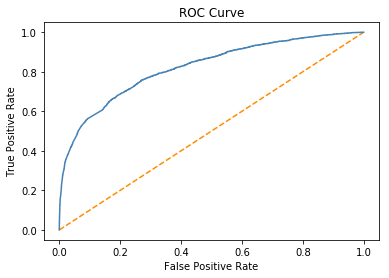

In [140]:
printMetrics(getMetrics(test.toxic, testPredictions, testProbPredictions))
showROC(test.toxic.as_matrix(), testProbPredictions[:, 1])

## Print metrics for train dataset

           P Neutral  P Toxic
T Neutral      84457    30964
T Toxic         6270   116080


           P Neutral   P Toxic
T Neutral   0.355203  0.130226
T Toxic     0.026370  0.488201


0.862


0.548


0.9436442591340435


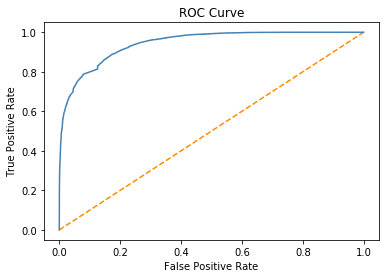

In [141]:
trainPredictions = model.predict(trainFeatures)
trainProbPredictions = model.predict_proba(trainFeatures)

printMetrics(getMetrics(trainOversampled.toxic, trainPredictions, trainProbPredictions))
showROC(trainOversampled.toxic.as_matrix(), trainProbPredictions[:, 1])

### Play with the model

In [21]:
def predict(sentence):
    return round(model.predict_proba(tfidf.transform([sentence]))[0][1], 3)

In [22]:
predict("<enter bad word here>")

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.131

## Export TP, FN and FP values

In [23]:
predictionsDF = pd.DataFrame(testProbPredictions[:, 1], columns=["prediction"])
zeroIndexedTest = test.reset_index().drop(["index"], axis=1)

testEvaluations = pd.concat([zeroIndexedTest, predictionsDF], axis=1)

In [24]:
tp = testEvaluations[(testEvaluations.toxic == 1) & (testEvaluations.prediction > 0.5)]
fn = testEvaluations[(testEvaluations.toxic == 1) & (testEvaluations.prediction <= 0.5)]
fp = testEvaluations[(testEvaluations.toxic == 0) & (testEvaluations.prediction > 0.5)]

In [25]:
print("Counts:\nTP: {}\nFN: {}\nFP: {}".format(tp.shape[0], fn.shape[0], fp.shape[0]))

Counts:
TP: 1840
FN: 1219
FP: 166


In [30]:
(tp[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/tp.csv", index=False))
(fn[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/fn.csv", index=False))
(fp[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/fp.csv", index=False))